In [4]:
import os 
import time
import torch 
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt 

# from train_mlp_ae import * 
# from trainer import AE_Trainer
from trainer_02 import AE_Trainer
from mlp_ae import MLPVAE, MLP_VQVAE, vae_loss, vqvae_loss
from cnn_ae import CNN_VAE

ModuleNotFoundError: No module named 'trainer_02'

In [2]:
import os
import numpy as np
import yaml
import matplotlib.pyplot as plt

def plot_losses(directory_list, legend, title1=None, title2=None, max_loss=None, time_scale=20):
    """
    Plots training and validation losses from a list of directories.
    
    Args:
        directory_list (list): List of paths to experiment directories.
        legend (list): List of strings for the legend labels.
        max_loss (float, optional): If provided, clips loss values > max_loss.
        time_scale (float, optional): The maximum value for the x-axis (e.g., 20).
                                      Data will be scaled to fit 0 to time_scale.
    """
    
    # Initialize two separate figures
    fig_train, ax_train = plt.subplots(figsize=(10, 6))
    fig_val, ax_val = plt.subplots(figsize=(10, 6))
    
    counter = 0
    
    # Iterate through each directory provided
    for directory in directory_list:
        if not os.path.exists(directory):
            print(f"Warning: Directory '{directory}' not found. Skipping.")
            continue

        # Get list of .npy files in the directory
        try:
            files = [f for f in os.listdir(directory) if f.endswith('.npy')]
        except NotADirectoryError:
             print(f"Warning: '{directory}' is not a directory. Skipping.")
             continue

        # Identify train and validation files based on keywords
        train_file = next((f for f in files if 'log_' in f.lower()), None)
        val_file = next((f for f in files if 'val' in f.lower()), None)
        
        print(f"Found training file indicator: {train_file} in {directory}")
        
        # Use the directory name as the label for the plot legend
        label_name = os.path.basename(os.path.normpath(directory))
        current_legend = legend[counter] if counter < len(legend) else label_name

        # --- Process Training Data ---
        if train_file:
            train_path = os.path.join(directory, "losses.npy")
            
            if os.path.exists(train_path):
                train_data = np.load(train_path)
                
                # 1. Handle Clipping
                if max_loss is not None:
                    if train_data.ndim == 1:
                        train_data = np.minimum(train_data, max_loss)
                    elif train_data.ndim == 2:
                        train_data[:, 1] = np.minimum(train_data[:, 1], max_loss)

                # 2. Handle Time Scaling (Attaching X-axis array)
                x_vals = None
                y_vals = None
                
                if train_data.ndim == 1:
                    # Case: 1D Data (Loss only)
                    y_vals = train_data
                    # Explicitly create an array from 0 to time_scale
                    if len(y_vals) > 0:
                        x_vals = np.linspace(0, time_scale, len(y_vals))
                    else:
                        x_vals = np.array([])
                elif train_data.ndim == 2:
                    # Case: 2D Data (Time, Loss)
                    x_raw = train_data[:, 0]
                    y_vals = train_data[:, 1]
                    # Normalize existing time column to 0 - time_scale
                    if len(x_raw) > 0:
                        x_min, x_max = x_raw.min(), x_raw.max()
                        if x_max > x_min:
                            x_vals = (x_raw - x_min) / (x_max - x_min) * time_scale
                        else:
                            x_vals = np.zeros_like(x_raw)
                    else:
                         x_vals = np.array([])

                # Plot with the attached x-scale
                ax_train.plot(x_vals, y_vals, label=current_legend)
            else:
                print(f"Expected 'losses.npy' not found in {directory}")
        else:
            print(f"No training file found in {directory}")

        # --- Process Validation Data ---
        if val_file:
            val_path = os.path.join(directory, val_file)
            val_data = np.load(val_path)
            
            # 1. Handle Clipping
            if max_loss is not None:
                if val_data.ndim == 1:
                    val_data = np.minimum(val_data, max_loss)
                elif val_data.ndim == 2:
                    val_data[:, 1] = np.minimum(val_data[:, 1], max_loss)

            # 2. Handle Time Scaling
            x_vals_val = None
            y_vals_val = None
            
            if val_data.ndim == 1:
                y_vals_val = val_data
                if len(y_vals_val) > 0:
                    x_vals_val = np.linspace(0, time_scale, len(y_vals_val))
                else:
                    x_vals_val = np.array([])
            elif val_data.ndim == 2:
                x_raw = val_data[:, 0]
                y_vals_val = val_data[:, 1]
                if len(x_raw) > 0:
                    x_min, x_max = x_raw.min(), x_raw.max()
                    if x_max > x_min:
                        x_vals_val = (x_raw - x_min) / (x_max - x_min) * time_scale
                    else:
                        x_vals_val = np.zeros_like(x_raw)
                else:
                    x_vals_val = np.array([])

            ax_val.plot(x_vals_val, y_vals_val, label=current_legend)
        else:
            print(f"No validation file found in {directory}")
            
        counter += 1

    # --- Formatting Training Plot ---
    ax_train.set_title("Training Losses Comparison")
    ax_train.set_xlabel(f"Scaled Time (0-{time_scale})")
    ax_train.set_ylabel("Loss")
    if max_loss:
        title = title1 + f"(Clipped at {max_loss})"
        ax_train.set_title(title)
    
    # Increased legend size here
    ax_train.legend(fontsize=16)
    ax_train.grid(True, alpha=0.3)

    # --- Formatting Validation Plot ---
    ax_val.set_title("Validation Losses Comparison")
    ax_val.set_xlabel(f"Scaled Time (0-{time_scale})")
    ax_val.set_ylabel("Loss")
    if max_loss:
        title = title2 + f"(Clipped at {max_loss})"
        ax_val.set_title(title)
    
    # Increased legend size here
    ax_val.legend(fontsize=16)
    ax_val.grid(True, alpha=0.3)

    plt.show()

In [4]:
src_dir = "/extra_storage/three_piece_assembly_latent_actions/buf.pkl"
n_test = 2 
n_val = 10
ac_chunk = 32
obs_dim = [11, 1]
ac_dim = [31, 10]
batch_size = 50
action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val, 
                                            mode="train",
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
val_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="val", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
test_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="test", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim) 

train_loader = DataLoader(action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10)
val_loader = DataLoader(val_action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10) 
test_loader = DataLoader(test_action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10) 

Mode: train, Index list length: 188


100%|██████████| 188/188 [00:01<00:00, 155.11it/s]


Mode: val, Index list length: 10


100%|██████████| 10/10 [00:00<00:00, 188.02it/s]


Mode: test, Index list length: 2


100%|██████████| 2/2 [00:00<00:00, 158.93it/s]


In [9]:
model_type = "CNN_VAE"
ac_chunk = 32
obs_dim = [9, 1]
ac_dim = [32, 10]
latent_dim = 256
channels = [64,128,256]
dec_in_padding = [1, 1, 1]
dec_out_padding = [1, 1, 1]
model = CNN_VAE(ac_chunk, obs_dim[0], ac_dim[-1], channels,dec_in_padding, dec_out_padding, latent_dim)
loss_fn = vae_loss
save_dir = "lr_sweep"
optim_params = {"log_freq": 100,
                "save_freq": 1000,
                "epochs": 20}

learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
for lr in learning_rates:
    optim_params["lr"] = lr
    trainer = AE_Trainer(model, 
                         loss_fn, 
                         "cuda:0", 
                         optim_params, 
                         f"cnn_lr_sweep_{lr}")
    trainer.train_loop(train_loader, val_loader,1000, arch="conv")

{'log_freq': 100, 'save_freq': 1000, 'epochs': 20, 'lr': 0.1}
Starting training for 20 epochs, 1000 steps per epoch.
Step 100 | Logged Loss: 0.09931
Step 200 | Logged Loss: 0.06760
Step 300 | Logged Loss: 0.06415
Step 400 | Logged Loss: 0.06063
Step 500 | Logged Loss: 0.05924
Step 600 | Logged Loss: 0.05603
Step 700 | Logged Loss: 0.05456
Step 800 | Logged Loss: 0.05082
Step 900 | Logged Loss: 0.04762
Step 1000 | Logged Loss: 0.04412
Step 1000 | Val Loss: 0.04311 | Saving checkpoint...
End of Epoch 0 | Avg Epoch Loss: 0.06041
Step 1100 | Logged Loss: 0.04178
Step 1200 | Logged Loss: 0.04115
Step 1300 | Logged Loss: 0.04063
Step 1400 | Logged Loss: 0.04042
Step 1500 | Logged Loss: 0.03953
Step 1600 | Logged Loss: 0.03933
Step 1700 | Logged Loss: 0.03906
Step 1800 | Logged Loss: 0.03890
Step 1900 | Logged Loss: 0.03858
Step 2000 | Logged Loss: 0.03769
Step 2000 | Val Loss: 0.03803 | Saving checkpoint...
End of Epoch 1 | Avg Epoch Loss: 0.03971
Step 2100 | Logged Loss: 0.03760
Step 2200 |

Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.1
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.01
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.001
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.0001
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_lr_sweep_1e-05


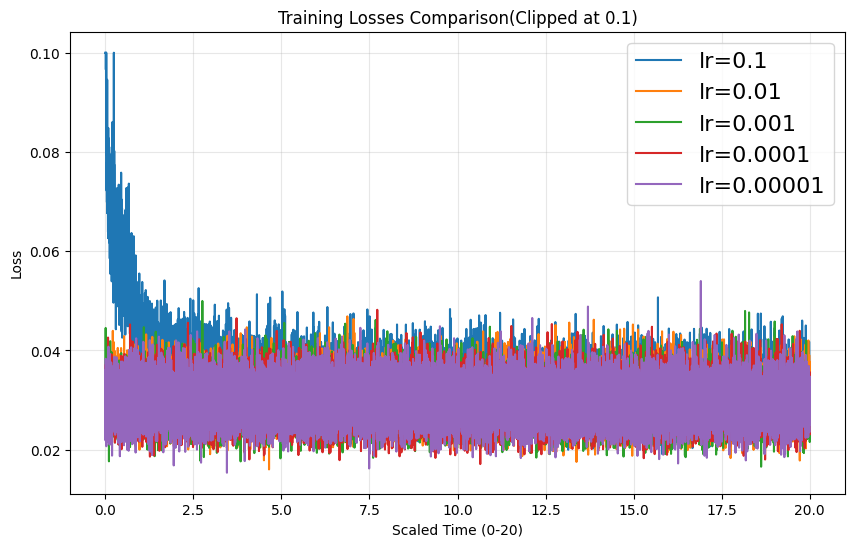

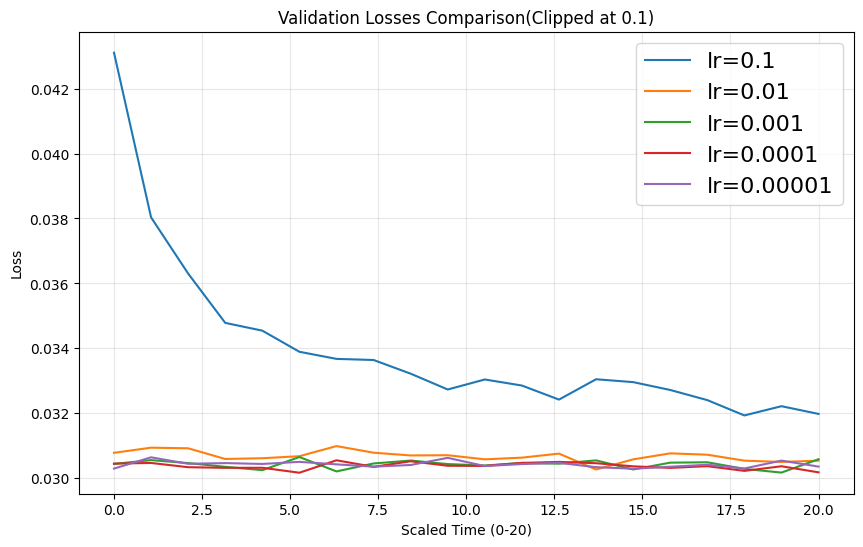

In [12]:
directories_to_plot = [
    '/home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.1',
    '/home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.01',
    '/home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.001', 
    '/home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.0001',
    '/home/blank/cs282_project/latent_actions/cnn_lr_sweep_1e-05' 
    ]
plot_losses(directories_to_plot, ["lr=0.1","lr=0.01","lr=0.001", "lr=0.0001", "lr=0.00001"], "Training Losses Comparison",
            "Validation Losses Comparison", max_loss = 0.1)

In [1]:
src_dir = "/extra_storage/three_piece_assembly_latent_actions/buf.pkl"
n_test = 2 
n_val = 10
ac_chunk = 32
obs_dim = [9, 1]
ac_dim = [32, 10]
batch_size = 50
action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val, 
                                            mode="train",
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
val_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="val", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
test_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="test", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim) 

model_type = "CNN_VAE"
ac_chunk = 32
obs_dim = [9, 1]
ac_dim = [32, 10]
latent_dim = 256
channels = [64,128,256]
dec_in_padding = [1, 1, 1]
dec_out_padding = [1, 1, 1]
model = CNN_VAE(ac_chunk, obs_dim[0], ac_dim[-1], channels,dec_in_padding, dec_out_padding, latent_dim)
loss_fn = vae_loss
save_dir = "lr_sweep"
optim_params = {"log_freq": 100,
                "save_freq": 1000,
                "epochs": 20,
                "lr": 0.001}


    

batch_sizes = [10, 20, 50, 100, 150]

for size in batch_sizes:
    train_loader = DataLoader(action_dataset, 
                                    batch_size = batch_size, 
                                    shuffle = True, 
                                    num_workers=10)
    val_loader = DataLoader(val_action_dataset, 
                                    batch_size = batch_size, 
                                    shuffle = True, 
                                    num_workers=10) 
    test_loader = DataLoader(test_action_dataset, 
                                    batch_size = batch_size, 
                                    shuffle = True, 
                                    num_workers=10) 
    trainer = AE_Trainer(model, 
                         loss_fn, 
                         "cuda:0", 
                         optim_params, 
                         f"cnn_batch_size_sweep_{size}")
    trainer.train_loop(train_loader, val_loader, 1000, arch="conv")

NameError: name 'LatentActionBuffer' is not defined

In [ ]:
directories_to_plot = [
    '/home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.1',
    '/home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.01',
    '/home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.001', 
    '/home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.0001',
    '/home/blank/cs282_project/latent_actions/cnn_lr_sweep_1e-05' 
    ]
plot_losses(directories_to_plot, ["lr=0.1","lr=0.01","lr=0.001", "lr=0.0001", "lr=0.00001"], "Training Losses Comparison",
            "Validation Losses Comparison", max_loss = 0.1)

In [ ]:
src_dir = "/extra_storage/three_piece_assembly_latent_actions/buf.pkl"
n_test = 2 
n_val = 10
ac_chunk = 32
obs_dim = [9, 1]
ac_dim = [32, 10]
batch_size = 50
action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val, 
                                            mode="train",
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
val_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="val", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
test_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="test", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim) 

train_loader = DataLoader(action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10)
val_loader = DataLoader(val_action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10) 
test_loader = DataLoader(test_action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10)

model_type = "CNN_VAE"
ac_chunk = 32
obs_dim = [9, 1]
ac_dim = [32, 10]
latent_dim = 256
channels = [64,128,256]
dec_in_padding = [1, 1, 1]
dec_out_padding = [1, 1, 1]
model = CNN_VAE(ac_chunk, obs_dim[0], ac_dim[-1], channels,dec_in_padding, dec_out_padding, latent_dim)
loss_fn = vae_loss
save_dir = "lr_sweep"
optim_params = {"log_freq": 100,
                "save_freq": 1000,
                "epochs": 100, 
                "lr": 0.001}

trainer = AE_Trainer(model, 
                         loss_fn, 
                         "cuda:0", 
                         optim_params, 
                         f"test_cnn_vae")
trainer.train_loop(train_loader, val_loader,1000, arch="conv")



Mode: train, Index list length: 188


100%|██████████| 188/188 [00:01<00:00, 144.01it/s]


Mode: val, Index list length: 10


100%|██████████| 10/10 [00:00<00:00, 184.52it/s]


Mode: test, Index list length: 2


100%|██████████| 2/2 [00:00<00:00, 168.92it/s]

{'log_freq': 100, 'save_freq': 1000, 'epochs': 100, 'lr': 0.001}


Starting training for 100 epochs, 1000 steps per epoch.
Step 100 | Logged Loss: 0.31863
Step 200 | Logged Loss: 0.20800
Step 300 | Logged Loss: 0.15773
Step 400 | Logged Loss: 0.12626
Step 500 | Logged Loss: 0.11027
Step 600 | Logged Loss: 0.10214
Step 700 | Logged Loss: 0.09654
Step 800 | Logged Loss: 0.09171
Step 900 | Logged Loss: 0.08827
Step 1000 | Logged Loss: 0.08623
Step 1000 | Val Loss: 0.08277 | Saving checkpoint...
End of Epoch 0 | Avg Epoch Loss: 0.13858
Step 1100 | Logged Loss: 0.08230
Step 1200 | Logged Loss: 0.08112
Step 1300 | Logged Loss: 0.07898
Step 1400 | Logged Loss: 0.07717
Step 1500 | Logged Loss: 0.07544
Step 1600 | Logged Loss: 0.07498


KeyboardInterrupt: 